# SCD30 Check
This notebook is simply to check how well the scd30 sensors are working on a select few beacons. 

[Data Import](#Data-Import)

[Data Visualization](#Data-Visualization)
 - [Time Series](#Time-Series)
 - [Heatmaps](#Heatmaps)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

# Data Import

In [2]:
# Beacon batch test 1
beacon_list = [14,37,43]
start_time = datetime(2020,7,9,16)
end_time = datetime(2020,7,10,12)

In [16]:
# Beacon batch test 2
beacon_list = [4,9,45]
start_time = datetime(2020,7,10,11)
end_time = datetime(2020,7,11,9)

In [10]:
beacon_data = pd.DataFrame()
print('Reading for beacon:')
for beacon in beacon_list:
    print(f'\t{beacon}')
    beacon_df = pd.DataFrame()
    if beacon < 10:
        number = f'0{beacon}'
    else:
        number = f'{beacon}'
    py3_df = pd.DataFrame()
    for file in os.listdir(f'/Users/hagenfritz/Projects/utx000/data/raw/bpeace2/beacon/B{number}/adafruit/'):
        try:
            day_df = pd.read_csv(f'/Users/hagenfritz/Projects/utx000/data/raw/bpeace2/beacon/B{number}/adafruit/{file}',
                                index_col='Timestamp',parse_dates=True,infer_datetime_format=True)
            py3_df = pd.concat([py3_df,day_df])
        except Exception as inst:
            print(f'{inst}; filename: {file}')
    py3_df = py3_df.resample('5T').mean()
    py2_df = pd.DataFrame()
    for file in os.listdir(f'/Users/hagenfritz/Projects/utx000/data/raw/bpeace2/beacon/B{number}/sensirion/'):
        try:
            day_df = pd.read_csv(f'/Users/hagenfritz/Projects/utx000/data/raw/bpeace2/beacon/B{number}/sensirion/{file}',
                            index_col='Timestamp',parse_dates=True,infer_datetime_format=True)
        except Exception as inst:
            print(f'{inst}; filename: {file}')
        py2_df = pd.concat([py2_df,day_df])
        
    py2_df = py2_df.resample('5T').mean()
        
    beacon_df = py3_df.merge(right=py2_df,left_index=True,right_index=True,how='outer')
    beacon_df['Beacon'] = beacon
    
    beacon_data = pd.concat([beacon_data,beacon_df])

Reading for beacon:
	4
No columns to parse from file; filename: b04_2020-03-22.csv
	9
	45


In [11]:
beacon_data.head()

,TVOC,eCO2,Lux,Visible,Infrared,NO2,T_NO2,RH_NO2,CO,T_CO,...,PM_N_0p5,PM_N_1,PM_N_2p5,PM_N_4,PM_N_10,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,Beacon
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-05-23 20:20:00,0.0,400.0,6.96864,39325.40,0.6,2776.25,31.0,41.0,1287869.25,31.00,...,24.644667,32.622219,35.201699,35.513169,35.560278,4.410649,6.925734,8.648939,8.715139,4
2020-05-23 20:25:00,0.0,400.0,3.50880,1.72,0.0,947.76,30.2,39.2,356681.40,30.60,...,17.959422,27.713981,31.826716,32.330659,32.406328,4.105203,8.069461,10.865770,10.973190,4
2020-05-23 20:30:00,0.0,400.0,2.04000,1.00,0.0,480.12,29.0,39.0,52500.64,29.52,...,24.484275,40.843789,48.185089,49.087238,49.222508,6.288719,13.348722,18.357510,18.549922,4
2020-05-23 20:35:00,0.0,400.0,2.04000,1.00,0.0,322.60,28.9,39.0,36968.35,29.00,...,21.263273,33.083248,38.106089,38.721779,38.814212,4.921662,9.761729,13.178366,13.309617,4
2020-05-23 20:40:00,0.0,400.0,2.04000,1.00,0.0,246.36,28.0,39.0,30278.68,28.40,...,17.834598,29.564854,34.806843,35.450893,35.547473,4.538675,9.580561,13.156236,13.293595,4


# Data Visualization
Now we visually inspect the data.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

## Time Series

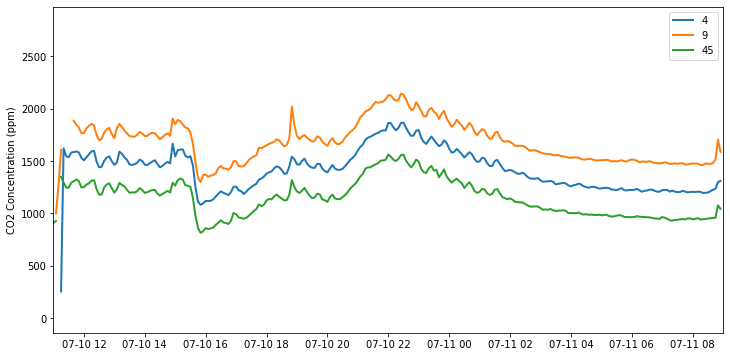

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
for num in beacon_data['Beacon'].unique():
    df_to_plot = beacon_data[beacon_data['Beacon'] == num]
    ax.plot(df_to_plot.index,df_to_plot['CO2'],linewidth=2,label=num)
    
ax.set_xlim([start_time,end_time])
ax.set_ylabel('CO2 Concentration (ppm)')
ax.legend()

plt.show()
plt.close()

## Heatmaps

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


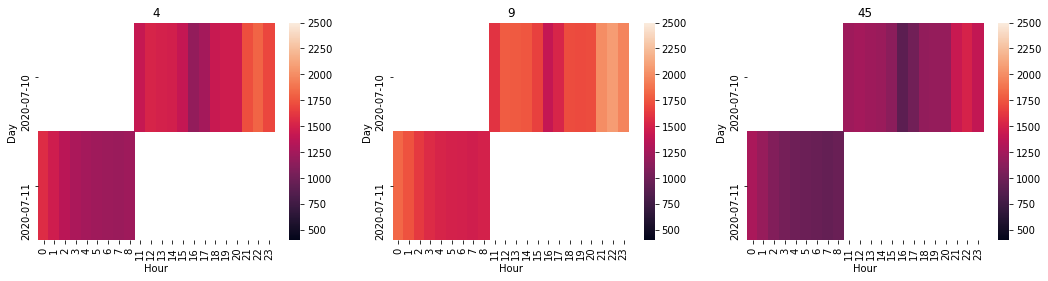

In [18]:
fig,ax = plt.subplots(1,3,figsize=(18,4))
loc = 0
for num in beacon_data['Beacon'].unique():
    # Getting dataframe for beacon in correct timeframe
    df_beacon = beacon_data[beacon_data['Beacon'] == num]
    df_beacon_timeframe = df_beacon[start_time:end_time]
    # Getting columns to pivot on
    df_beacon_timeframe['Hour'] = df_beacon_timeframe.index.hour
    df_beacon_timeframe['Day'] = df_beacon_timeframe.index.date
    # pivoting and plotting
    df_to_plot = df_beacon_timeframe.pivot_table(index='Day',columns='Hour',values='CO2')
    sns.heatmap(df_to_plot,vmin=400,vmax=2500,ax=ax[loc])
    ax[loc].set_title(num)
    
    loc += 1
    
plt.show()
plt.close()